The $AR(1)$ process is defined as:
$$X_t = \rho X_{t-1} + \epsilon_t$$
where $\epsilon_t \sim N(0, \sigma^2)$ is white noise and $|\rho| < 1$.

Let us assign the following prior distributions to the parameters:
- $\rho \sim \text{Uniform}(-1, 1)$
- $\sigma \sim \text{Uniform}(0, A)$

We can determine the likelihood by conditioning on $X_0$:
$$
\begin{aligned}
p(\vec x | \rho, \sigma) \quad &\propto \quad (\sigma^2)^{-\frac{T}{2}} \exp\left(-\frac{1}{2\sigma^2} \sum_{t=1}^{T} (x_t - \rho x_{t-1})^2\right) \\
&= \quad (\sigma^2)^{-\frac{T}{2}} \exp\left(-\frac{S(\rho)}{2\sigma^2}\right) \\
\end{aligned}
$$
Where:
$$
\begin{aligned}
S(\rho) &:= \sum_{t=1}^{T} (x_t - \rho x_{t-1})^2 \\
&= \sum_{t=1}^{T} (x_t^2 - 2\rho x_t x_{t-1} + \rho^2 x_{t-1}^2) \\
&= \sum_{t=1}^{T} x_t^2 - 2\rho \sum_{t=1}^{T} x_t x_{t-1} + \rho^2 \sum_{t=1}^{T} x_{t-1}^2 \\
&= Q(\rho^2 - 2\rho \hat \rho)  + const 
 \quad \quad \quad\quad  \text{where} \quad Q := \sum_{t=1}^{T} x_{t-1}^2, \quad \hat \rho := \frac{\sum_{t=1}^{T} x_t x_{t-1}}{Q} \\
&= Q(\rho - \hat \rho)^2 + const
\end{aligned}
$$
## rho conditional
Therefore, we can write the conditional posterior distribution as:
$$
\begin{aligned}
p(\rho|  \sigma , \vec x) \quad &\propto \quad  \sigma^{-T/2} \exp\left(-\frac{Q}{2\sigma^2}(\rho - \hat \rho)^2\right)  \mathbb I_A

\end{aligned}
$$
where we condition on the event $A = \{|\rho| < 1, 0 < \sigma < A\}$.

Ie, we have a normal distribution:
$$
\rho | \sigma, \vec x \sim N\left(\hat \rho, \frac{\sigma^2}{Q}\right)
$$
where we truncate to the interval $(-1, 1)$.

## sigma conditional

Let us first change variables $\lambda := 1/\sigma^2$. Then we have $\left | \frac{d\sigma}{d\lambda} \right | = \frac{1}{2} \lambda^{-3/2}$. The posterior is then:
$$
\begin{aligned}
p(\lambda | \rho, \vec x) \quad &\propto \quad \lambda^{\frac{T}{2} - \frac{3}{2}} \exp\left(-\frac{\lambda}{2} S(\rho)\right) \mathbb I_B\\
\end{aligned}
$$
This is a Gamma distribution:
$$
\lambda | \rho, \vec x \sim \text{Gamma}\left(\frac{T}{2} - \frac{1}{2}, \frac{S(\rho)}{2}\right)
$$
but we must truncate on $\lambda > 1/A^2$.

## Maths

### Standard Neural Network Training

We want our neural network $f_\phi(\vec{x})$ to minimize the expected squared error:
$$
\mathcal{L}(\phi) = \mathbb{E}_{\theta \sim p, \vec{x} \sim p(\cdot|\theta)}\left[(f_\phi(\vec{x}) - \theta)^2\right]
$$

In practice, we approximate this with Monte Carlo sampling:
$$
\mathcal{L}(\phi) \approx \frac{1}{N} \sum_{i=1}^N (f_\phi(\vec{x}_i) - \theta_i)^2
$$
where $\theta_i \sim p(\theta)$ and $\vec{x}_i \sim p(\vec{x} | \theta_i)$.

### Importance Sampling Modification
Compute **importance weights**: $w(\theta) = \frac{p(\theta)}{q(\theta)}$
Use a **weighted loss**: $L_{\text{weighted}} = w(\theta) \cdot (f_\phi(\vec{x}) - \theta)^2$

Now suppose we sample $\theta$ from a different distribution $q(\theta)$ instead of $p(\theta)$. We can rewrite the expectation:
$$
\begin{aligned}
\mathcal{L}(\phi) &= \mathbb{E}_{\theta \sim p}\left[\mathbb{E}_{\vec{x} \sim p(\cdot|\theta)}\left[(f_\phi(\vec{x}) - \theta)^2\right]\right] \\
&= \int p(\theta) \mathbb{E}_{\vec{x} | \theta}\left[(f_\phi(\vec{x}) - \theta)^2\right] d\theta \\
&= \int \frac{p(\theta)}{q(\theta)} q(\theta) \mathbb{E}_{\vec{x} | \theta}\left[(f_\phi(\vec{x}) - \theta)^2\right] d\theta \\
&= \mathbb{E}_{\theta \sim q}\left[w(\theta) \cdot \mathbb{E}_{\vec{x} | \theta}\left[(f_\phi(\vec{x}) - \theta)^2\right]\right]
\end{aligned}
$$

where $w(\theta) = \frac{p(\theta)}{q(\theta)}$ is the **importance weight**.

### Monte Carlo Estimator with Importance Sampling

This gives us a new Monte Carlo estimator:
$$
\mathcal{L}(\phi) \approx \frac{1}{N} \sum_{i=1}^N w(\theta_i) \cdot (f_\phi(\vec{x}_i) - \theta_i)^2
$$
where now $\theta_i \sim q(\theta)$ (our proposal).

This is an **unbiased** estimator of the true loss, even though we're sampling from $q$ instead of $p$!

Weight stats: min=0.00, max=76.83, mean=0.96
Normalized weight stats: min=0.000000, max=0.016011


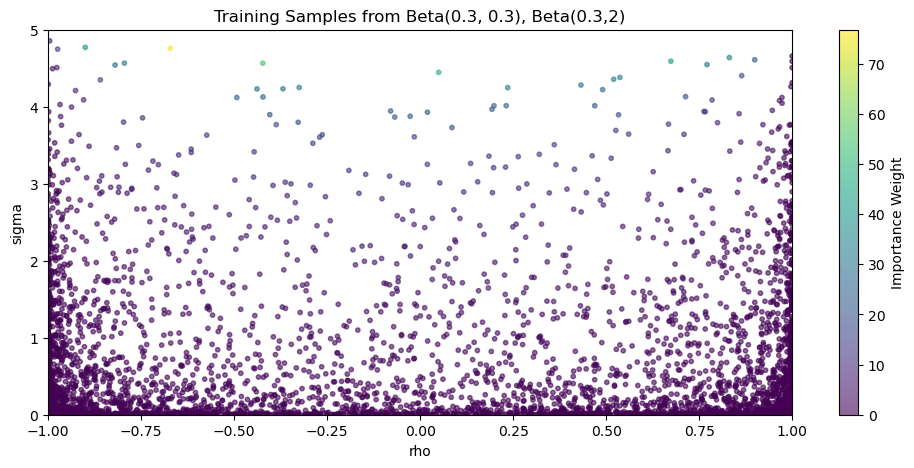

In [1]:
# Configuration: Importance Sampling Hyperparameters

# Proposal distribution parameters (Beta distribution)
# Lower alpha/beta = more extreme sampling at boundaries
# Higher alpha/beta = more uniform sampling

ALPHA_RHO = 0.3      # Beta parameter for rho proposal
ALPHA_SIGMA = 0.3
BETA_SIGMA = 2 # 1 or 1.5

# Model parameters
A = 5.0
T = 64

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Sample from Beta proposal (like training does)
n = 5000
rho_tilde = np.random.beta(ALPHA_RHO, ALPHA_RHO, n)
sigma_tilde = np.random.beta(ALPHA_SIGMA, BETA_SIGMA, n)
rho = 2 * rho_tilde - 1
sigma = A * sigma_tilde

# Compute importance weights
q_rho = stats.beta.pdf(rho_tilde, ALPHA_RHO, ALPHA_RHO) / 2
q_sigma = stats.beta.pdf(sigma_tilde, ALPHA_SIGMA, BETA_SIGMA) / A
weights = (1.0 / (2 * A)) / (q_rho * q_sigma)

# Normalize weights like in training
weights_norm = weights / weights.sum()

# Plot
plt.figure(figsize=(12, 5))
sc = plt.scatter(rho, sigma, c=weights, s=10, alpha=0.6, cmap='viridis')
plt.colorbar(sc, label='Importance Weight')
plt.xlabel('rho')
plt.ylabel('sigma')
plt.title(f'Training Samples from Beta({ALPHA_RHO}, {ALPHA_RHO}), Beta({ALPHA_SIGMA},{BETA_SIGMA})')
plt.xlim([-1, 1])
plt.ylim([0, A])

print(f"Weight stats: min={weights.min():.2f}, max={weights.max():.2f}, mean={weights.mean():.2f}")
print(f"Normalized weight stats: min={weights_norm.min():.6f}, max={weights_norm.max():.6f}")

# Gibbs sampler

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def truncated_normal(mu, sigma, a=-1, b=1):
    while True:
        sample = np.random.normal(mu, sigma)
        if a <= sample <= b:
            return sample

def truncated_gamma(shape, scale, a=1/A**2):
    while True:
        sample = np.random.gamma(shape, scale)
        if sample >= a:
            return sample

def gibbs(x, n_iter=1000):
    T = len(x) - 1

    Q = np.sum(x[:-1]**2)
    rho_hat = np.sum(x[:-1] * x[1:]) / Q
    const = np.sum(x[1:]**2) - Q * rho_hat**2
    
    S = lambda rho: Q * (rho - rho_hat)**2 + const
               
    samples = np.zeros((n_iter, 2))
    for i in range(n_iter):
        # Sample sigma
        lambda_ = truncated_gamma(T/2, 2/(S(rho_hat) + 1e-6))
        sigma = 1/np.sqrt(lambda_)
        samples[i, 1] = sigma

        # Sample rho
        samples[i, 0] = truncated_normal(rho_hat, sigma/np.sqrt(Q))

    return samples

In [3]:
# Importance Sampling Functions
from scipy import stats
import torch

def sample_from_proposal(batch_size, alpha_rho=None, alpha_sigma=None, beta_sigma=None, A=None, device='cpu'):
    """Sample (rho, sigma) from Beta-based proposal"""
    # Use config values if not specified
    if alpha_rho is None: alpha_rho = ALPHA_RHO
    if alpha_sigma is None: alpha_sigma = ALPHA_SIGMA
    if beta_sigma is None: beta_sigma = BETA_SIGMA
    if A is None: A = globals()['A']
    
    rho_tilde = np.random.beta(alpha_rho, alpha_rho, size=batch_size)
    sigma_tilde = np.random.beta(alpha_sigma, beta_sigma, size=batch_size)
    
    rho = 2 * rho_tilde - 1
    sigma = A * sigma_tilde
    
    rho = torch.tensor(rho, dtype=torch.float32, device=device)
    sigma = torch.tensor(sigma, dtype=torch.float32, device=device)
    
    return rho, sigma

def compute_importance_weights(rho, sigma, alpha_rho=None, alpha_sigma=None, beta_sigma=None, A=None):
    """Compute importance weights w = p(theta) / q(theta)"""
    # Use config values if not specified
    if alpha_rho is None: alpha_rho = ALPHA_RHO
    if alpha_sigma is None: alpha_sigma = ALPHA_SIGMA
    if beta_sigma is None: beta_sigma = BETA_SIGMA
    if A is None: A = globals()['A']
    
    if torch.is_tensor(rho):
        rho = rho.cpu().numpy()
        sigma = sigma.cpu().numpy()
    
    rho_tilde = (rho + 1) / 2
    sigma_tilde = sigma / A
    
    q_rho = stats.beta.pdf(rho_tilde, alpha_rho, alpha_rho) / 2
    q_sigma = stats.beta.pdf(sigma_tilde, alpha_sigma, beta_sigma) / A
    
    q_theta = q_rho * q_sigma
    p_theta = 1.0 / (2 * A)
    
    weights = p_theta / q_theta
    
    return weights

def simulate_ar1_batch(rho, sigma, T=None, batch_size=None, device='cpu'):
    """Vectorized AR(1) simulation with numerical stability"""
    if T is None: T = globals()['T']
    if batch_size is None: batch_size = len(rho)
    
    eps = torch.randn(batch_size, T, device=device) * sigma[:, None]
    
    # Clamp rho and add epsilon to prevent overflow
    rho_safe = torch.clamp(rho, -0.9999, 0.9999)
    x0 = torch.randn(batch_size, device=device) * sigma / torch.sqrt(1 - rho_safe**2 + 1e-8)
    
    x = torch.zeros(batch_size, T, device=device)
    x[:, 0] = rho * x0 + eps[:, 0]
    
    for t in range(1, T):
        x[:, t] = rho * x[:, t-1] + eps[:, t]
    
    return x

print("Importance sampling functions loaded")

Importance sampling functions loaded


# GRU Architecture

In [4]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060
CUDA Version: 12.1


In [5]:
import torch
import torch.nn as nn

class GRUPosteriorEstimator(nn.Module):
    def __init__(
        self,
        input_dim=1,
        hidden_dim=64,
        num_layers=2,
        output_dim=2,
        mlp_hidden=64
    ):
        super().__init__()
        
        # GRU layer to process sequential data
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        
        # MLP to map from GRU to parameter estimates
        self.estimator = nn.Sequential(
            nn.Linear(hidden_dim, mlp_hidden),
            nn.Tanh(),
            #nn.Dropout(0.1),
            nn.Linear(mlp_hidden, mlp_hidden),
            nn.Tanh(),
            #nn.Dropout(0.1),
            nn.Linear(mlp_hidden, output_dim)
        )
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        
        gru_out, h_n = self.gru(x)
           
        
        last_hidden = h_n[-1] 
        
        return self.estimator(last_hidden)

# Create the GRU model
gru_estimator = GRUPosteriorEstimator(
    input_dim=1,
    hidden_dim=64,
    num_layers=2,
    output_dim=2,
    mlp_hidden=64
).to(device)

# Test the model
x_test = torch.randn(4, 64).to(device)
output_test = gru_estimator(x_test)
print(f"Output shape: {output_test.shape}")
print(f"Model parameters: {sum(p.numel() for p in gru_estimator.parameters())}")

Output shape: torch.Size([4, 2])
Model parameters: 46274


In [ ]:
# Train GRU with Importance Sampling
from torch import nn

n_epochs = 128
n_batches_per_epoch = 128
training_batch_size = 128

gru_estimator = GRUPosteriorEstimator(
    input_dim=1,
    hidden_dim=64,
    num_layers=2,
    output_dim=2,
    mlp_hidden=64
).to(device)

optimizer = torch.optim.Adam(gru_estimator.parameters(), lr=0.004)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
loss_fn = nn.MSELoss(reduction='none')

train_losses_gru = []

print(f"Training with Beta({ALPHA_RHO}, {ALPHA_RHO}) for rho, Beta({ALPHA_SIGMA}, {BETA_SIGMA}) for sigma")
print("="*70)

# Generate a fixed test set
x_test = torch.randn(1024, T, device=device)
rho_test = torch.empty(1024, device=device).uniform_(-1, 1)
sigma_test = torch.empty(1024, device=device).uniform_(0, A)
x_test = simulate_ar1_batch(rho_test, sigma_test, T, 1024, device=device)

for epoch in range(n_epochs):
    gru_estimator.train()
    epoch_loss = 0.0
    
    for batch_idx in range(n_batches_per_epoch):
        # Sample from proposal (uses config parameters)
        rho, sigma = sample_from_proposal(training_batch_size, device=device)
        
        # Compute importance weights
        weights = compute_importance_weights(rho, sigma)
        weights = torch.tensor(weights, dtype=torch.float32, device=device)
        weights = torch.nan_to_num(weights, nan=1.0, posinf=10.0, neginf=0.1)
        
        # Clamp and normalize weights
        weights = torch.clamp(weights, min=0.1, max=10.0)
        weights = weights / weights.sum()
        
        # Simulate time series
        x = simulate_ar1_batch(rho, sigma, T, training_batch_size, device=device)
        
        if torch.isnan(x).any() or torch.isinf(x).any():
            continue
        
        # Forward pass
        theta_pred = gru_estimator(x)
        
        if torch.isnan(theta_pred).any() or torch.isinf(theta_pred).any():
            continue
        
        # Weighted loss
        loss_per_sample = ((theta_pred - torch.stack([rho, sigma], dim=1))**2).sum(dim=1)
        loss = torch.sum(weights * loss_per_sample)
        
        if torch.isnan(loss) or torch.isinf(loss):
            continue
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gru_estimator.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / n_batches_per_epoch
    train_losses_gru.append(avg_epoch_loss)
    
    # Evaluation on uniform test set
    gru_estimator.eval()
    with torch.no_grad():
        theta_pred_test = gru_estimator(x_test)
        test_loss = ((theta_pred_test - torch.stack([rho_test, sigma_test], dim=1))**2).mean().item()
    
    #scheduler.step(avg_epoch_loss)
    
    if (epoch + 1) % 8 == 0:
        ess = 1.0 / (weights**2).sum()
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_epoch_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, ESS: {ess.item():.1f}/{training_batch_size}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

Training with Beta(0.3, 0.3) for rho, Beta(0.3, 2) for sigma
Epoch 8/128, Train Loss: 0.5388, Test Loss: 0.3683, ESS: 28.7/128, LR: 0.000100
Epoch 16/128, Train Loss: 0.2184, Test Loss: 0.1355, ESS: 27.8/128, LR: 0.000100
Epoch 24/128, Train Loss: 0.1755, Test Loss: 0.1037, ESS: 23.9/128, LR: 0.000100
Epoch 32/128, Train Loss: 0.1589, Test Loss: 0.0846, ESS: 24.2/128, LR: 0.000100
Epoch 40/128, Train Loss: 0.1412, Test Loss: 0.0698, ESS: 34.1/128, LR: 0.000100
Epoch 48/128, Train Loss: 0.1285, Test Loss: 0.0650, ESS: 27.4/128, LR: 0.000100
Epoch 56/128, Train Loss: 0.1296, Test Loss: 0.0653, ESS: 26.6/128, LR: 0.000100
Epoch 64/128, Train Loss: 0.1134, Test Loss: 0.0603, ESS: 25.5/128, LR: 0.000100
Epoch 72/128, Train Loss: 0.1226, Test Loss: 0.0552, ESS: 24.7/128, LR: 0.000100
Epoch 80/128, Train Loss: 0.1139, Test Loss: 0.0527, ESS: 33.6/128, LR: 0.000100
Epoch 88/128, Train Loss: 0.1084, Test Loss: 0.0535, ESS: 27.3/128, LR: 0.000100
Epoch 96/128, Train Loss: 0.1214, Test Loss: 0.05

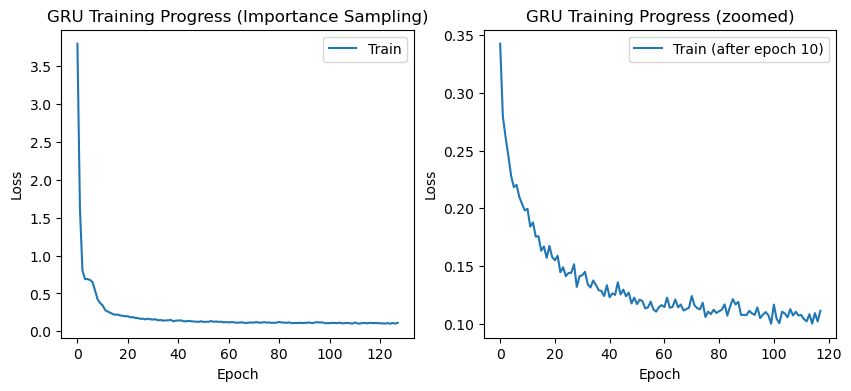

In [7]:
# Plot training progress for GRU
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_gru, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU Training Progress (Importance Sampling)')

plt.subplot(1, 2, 2)
plt.plot(train_losses_gru[10:], label='Train (after epoch 10)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU Training Progress (zoomed)')
plt.show()

In [8]:
# Evaluate IS GRU model and compare with Gibbs sampler
x_eval = torch.empty(1000, T, device='cpu')
rho_eval = torch.empty(1000, device='cpu').uniform_(-1, 1)
sigma_eval = torch.empty(1000, device='cpu').uniform_(0, A)
x_eval = simulate_ar1_batch(rho_eval, sigma_eval, T, 1000, device='cpu')

x_eval_np = x_eval.numpy()
rho_eval_np = rho_eval.numpy()
sigma_eval_np = sigma_eval.numpy()

# Gibbs sampler estimates
rho_gibbs_eval = np.zeros(1000)
sigma_gibbs_eval = np.zeros(1000)

print("Running Gibbs sampler for comparison...")
for i in range(1000):
    samples = gibbs(x_eval_np[i], n_iter=1000)
    rho_gibbs_eval[i] = np.mean(samples[:, 0])
    sigma_gibbs_eval[i] = np.mean(samples[:, 1])

# IS GRU estimates
gru_estimator.eval()
with torch.no_grad():
    x_eval_gpu = x_eval.to(device)
    gru_pred = gru_estimator(x_eval_gpu).cpu().numpy()
    rho_gru = gru_pred[:, 0]
    sigma_gru = gru_pred[:, 1]

print("Evaluation complete!")

Running Gibbs sampler for comparison...
Evaluation complete!


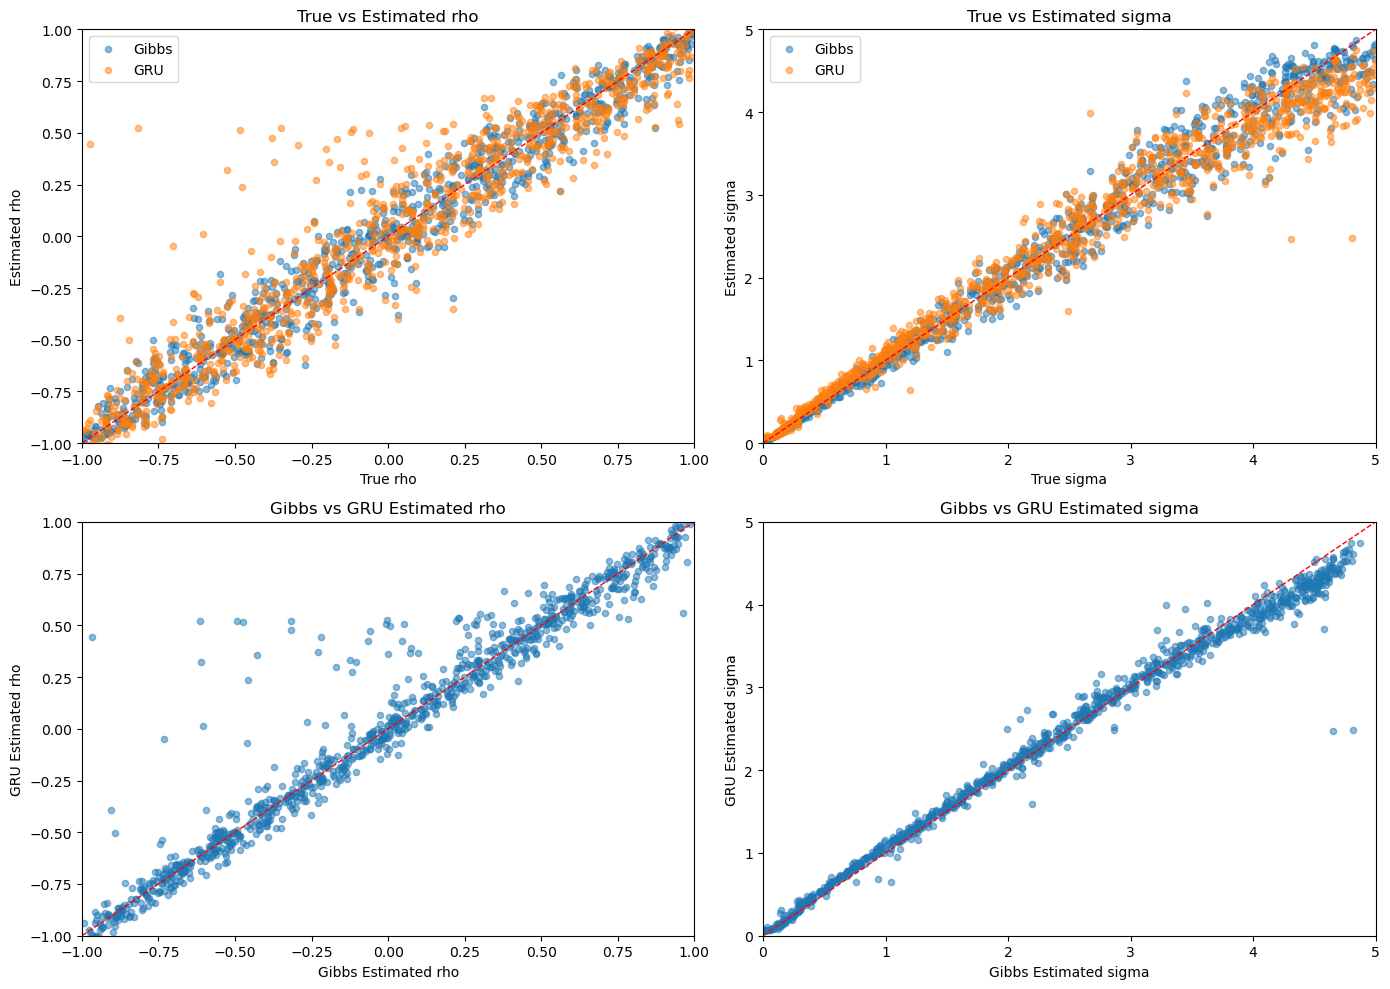

PERFORMANCE COMPARISON
MSE rho (Gibbs):  0.011653
MSE rho (GRU):    0.029481
Improvement:      -153.00%
------------------------------------------------------------
MSE sigma (Gibbs): 0.051455
MSE sigma (GRU):   0.079924
Improvement:       -55.33%


In [9]:
# Comprehensive comparison plot
plt.figure(figsize=(14, 10))

# Rho comparison
plt.subplot(2, 2, 1)
plt.scatter(rho_eval_np, rho_gibbs_eval, alpha=0.5, label='Gibbs', s=20)
plt.scatter(rho_eval_np, rho_gru, alpha=0.5, label='GRU', s=20)
plt.plot([-1, 1], [-1, 1], color='r', linestyle='dashed', linewidth=1)
plt.xlabel('True rho')
plt.ylabel('Estimated rho')
plt.title('True vs Estimated rho')
plt.legend()
plt.xlim([-1, 1])
plt.ylim([-1, 1])

# Sigma comparison
plt.subplot(2, 2, 2)
plt.scatter(sigma_eval_np, sigma_gibbs_eval, alpha=0.5, label='Gibbs', s=20)
plt.scatter(sigma_eval_np, sigma_gru, alpha=0.5, label='GRU', s=20)
plt.plot([0, A], [0, A], color='r', linestyle='dashed', linewidth=1)
plt.xlabel('True sigma')
plt.ylabel('Estimated sigma')
plt.title('True vs Estimated sigma')
plt.legend()
plt.xlim([0, A])
plt.ylim([0, A])

# gbbs vs gru for rho
plt.subplot(2, 2, 3)
plt.scatter(rho_gibbs_eval, rho_gru, alpha=0.5, s=20)
plt.plot([-1, 1], [-1, 1], color='r', linestyle='dashed', linewidth=1)
plt.xlabel('Gibbs Estimated rho')
plt.ylabel('GRU Estimated rho')
plt.title('Gibbs vs GRU Estimated rho')
plt.xlim([-1, 1])
plt.ylim([-1, 1])

# gbbs vs gru for sigma
plt.subplot(2, 2, 4)
plt.scatter(sigma_gibbs_eval, sigma_gru, alpha=0.5, s=20)
plt.plot([0, A], [0, A], color='r', linestyle='dashed', linewidth=1)
plt.xlabel('Gibbs Estimated sigma')
plt.ylabel('GRU Estimated sigma')
plt.title('Gibbs vs GRU Estimated sigma')
plt.xlim([0, A])
plt.ylim([0, A])

plt.tight_layout()
plt.show()

# Print MSE comparison
print("="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"MSE rho (Gibbs):  {np.mean((rho_eval_np - rho_gibbs_eval)**2):.6f}")
print(f"MSE rho (GRU):    {np.mean((rho_eval_np - rho_gru)**2):.6f}")
print(f"Improvement:      {(1 - np.mean((rho_eval_np - rho_gru)**2)/np.mean((rho_eval_np - rho_gibbs_eval)**2))*100:.2f}%")
print("-"*60)
print(f"MSE sigma (Gibbs): {np.mean((sigma_eval_np - sigma_gibbs_eval)**2):.6f}")
print(f"MSE sigma (GRU):   {np.mean((sigma_eval_np - sigma_gru)**2):.6f}")
print(f"Improvement:       {(1 - np.mean((sigma_eval_np - sigma_gru)**2)/np.mean((sigma_eval_np - sigma_gibbs_eval)**2))*100:.2f}%")
print("="*60)

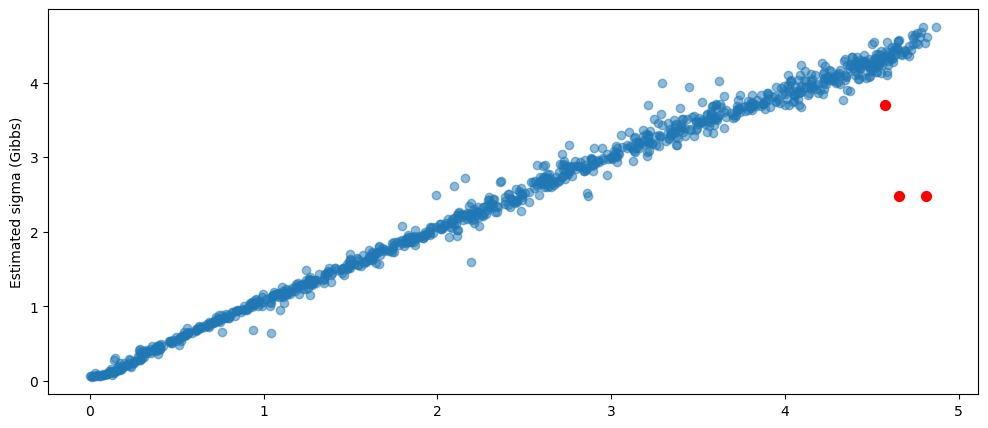

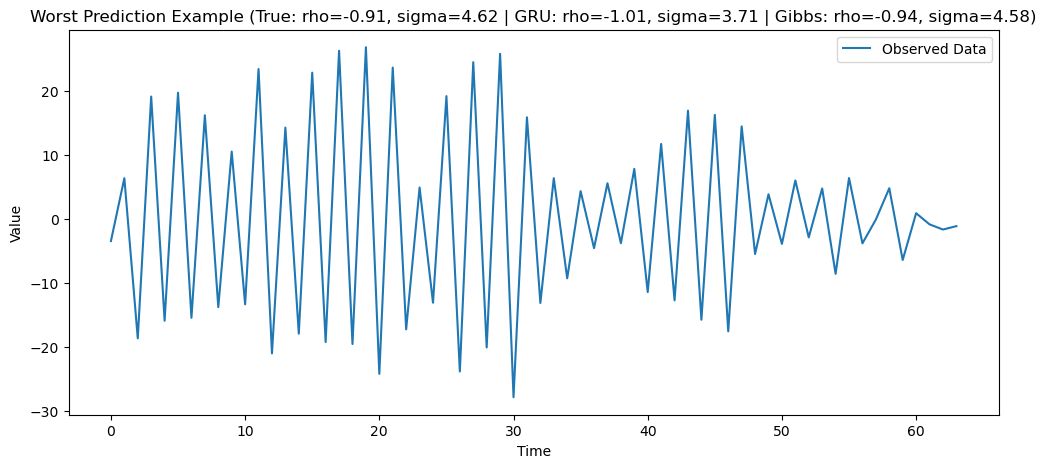

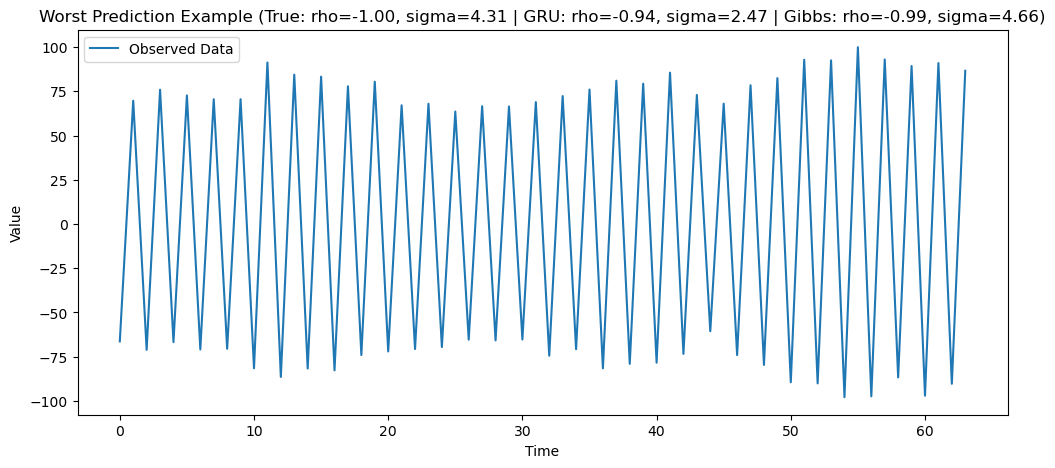

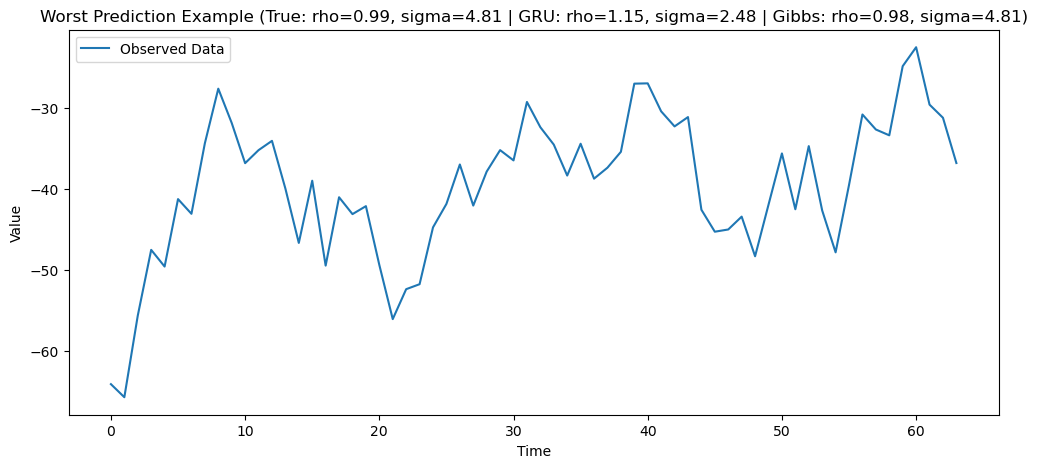

In [10]:
# now view the worse
worst_indices = np.argsort((sigma_gru - sigma_gibbs_eval)**2)[-3:]

# plot the worst cases in red
plt.figure(figsize=(12, 5))
plt.scatter(sigma_gibbs_eval, sigma_gru, alpha=0.5)
plt.scatter(sigma_gibbs_eval[worst_indices], sigma_gru[worst_indices], color='r', label='Worst Cases', s=50)
plt.ylabel('Estimated sigma (Gibbs)')
plt.show()

for idx in worst_indices:
    plt.figure(figsize=(12, 5))
    plt.plot(x_eval_np[idx], label='Observed Data')
    plt.title(f"Worst Prediction Example (True: rho={rho_eval_np[idx]:.2f}, sigma={sigma_eval_np[idx]:.2f} | GRU: rho={rho_gru[idx]:.2f}, sigma={sigma_gru[idx]:.2f} | Gibbs: rho={rho_gibbs_eval[idx]:.2f}, sigma={sigma_gibbs_eval[idx]:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

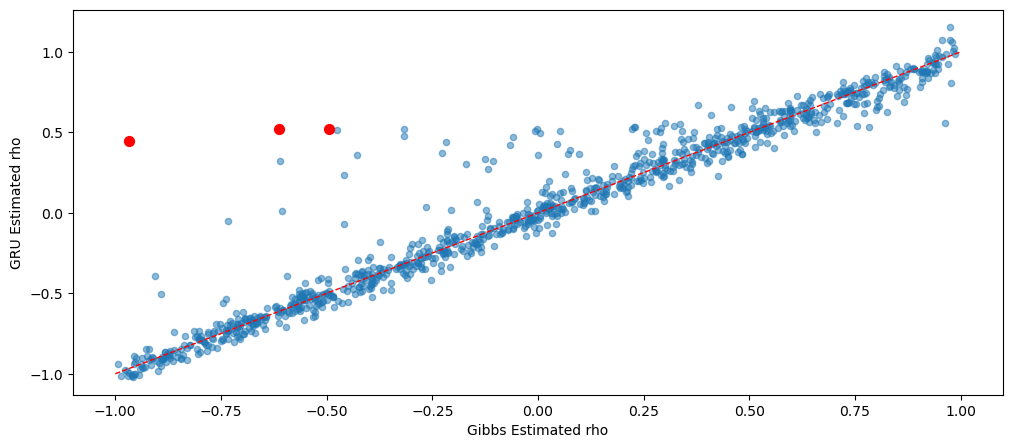

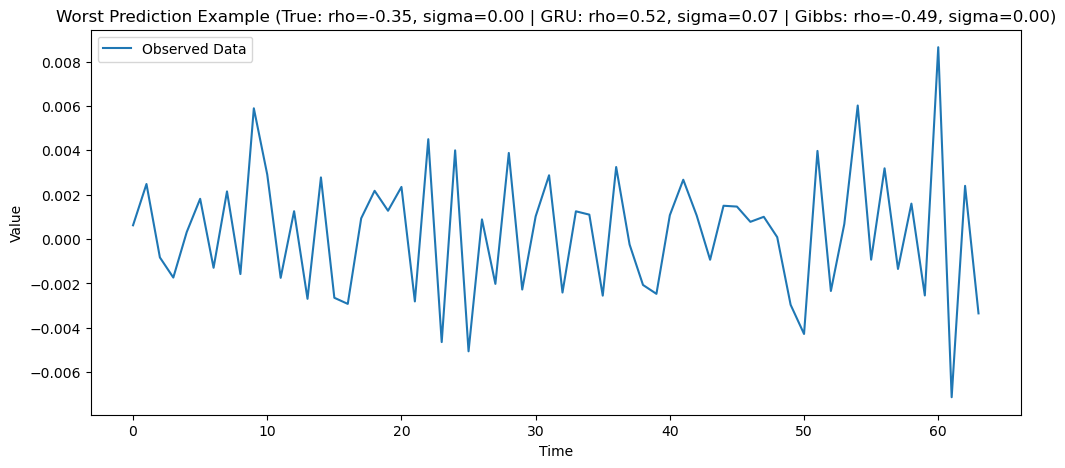

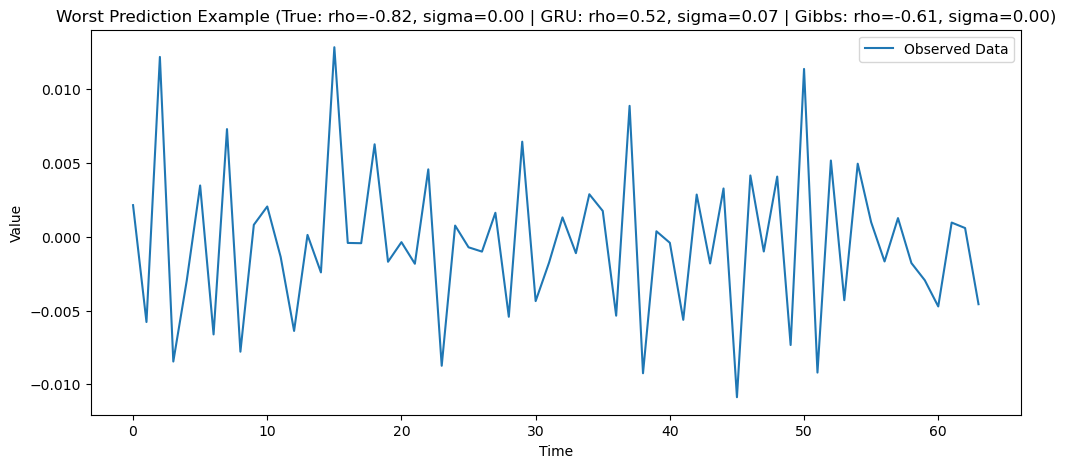

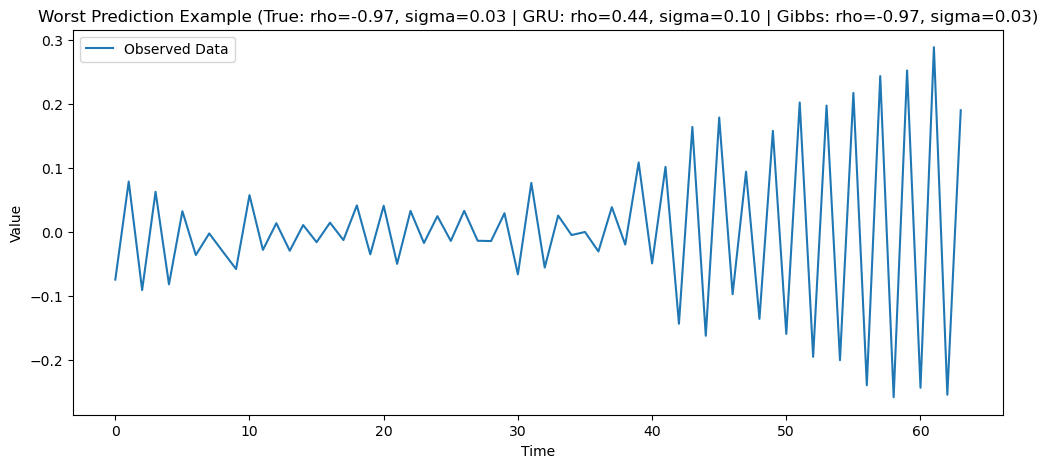

In [11]:
# lets view the worsst neural network predictions
worst_indices = np.argsort((rho_gru - rho_gibbs_eval)**2)[-3:]

# plot the worst predictions in red
plt.figure(figsize=(12, 5))
plt.scatter(rho_gibbs_eval, rho_gru, alpha=0.5, label='GRU', s=20)
plt.scatter(rho_gibbs_eval[worst_indices], rho_gru[worst_indices], color='r', label='Worst Predictions', s=50)
plt.plot([-1, 1], [-1, 1], color='r', linestyle='dashed', linewidth=1)
plt.xlabel('Gibbs Estimated rho')
plt.ylabel('GRU Estimated rho')
plt.show()


for idx in worst_indices:
    plt.figure(figsize=(12, 5))
    plt.plot(x_eval_np[idx], label='Observed Data')
    plt.title(f"Worst Prediction Example (True: rho={rho_eval_np[idx]:.2f}, sigma={sigma_eval_np[idx]:.2f} | GRU: rho={rho_gru[idx]:.2f}, sigma={sigma_gru[idx]:.2f} | Gibbs: rho={rho_gibbs_eval[idx]:.2f}, sigma={sigma_gibbs_eval[idx]:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()